# Introduction

Ce *notebook* vise à illustrer les méthodes associée à l'approche dite de ***"Couplage mécano-fiabiliste"*** sur des exemples simples en 2 dimensions permettant de visualiser les étapes, les hypothèses et les limites des méthodes vues au cours de la formation fiabilité.

La mise en oeuvre de ces méthodes s'appuie sur les modules Python suivants (essentiellement **OpenTURNS**) :

In [1]:
import openturns as ot
ot.ResourceMap.SetAsNumericalScalar('DistributionImplementation-DefaultQuantileEpsilon', 1e-6)
#from otsubset import SubsetSampling
from openturns.viewer import View
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
%pylab --no-import-all inline
from mpl_toolkits.mplot3d import Axes3D
rcParams = { 'axes.grid': False,
             'axes.hold': True,
             'axes.labelsize': 16,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             #'ztick.labelsize': 12,
             'axes.linewidth': 0.5,
             'font.size': 16,
             'image.cmap': 'gray',
             'image.interpolation': 'bilinear',
             'legend.fontsize': 16,
             'legend.shadow': True,
             'lines.linewidth': 1.5,
             'text.latex.unicode': True}
pl.rcParams.update(rcParams)
light_gray = pl.matplotlib.colors.LinearSegmentedColormap.from_list(
                'light_gray', [[.9] * 3, [.6] * 3])
class FormatFaker(object):
    def __init__(self, str): self.str = str
    def __mod__(self, stuff): return self.str

Populating the interactive namespace from numpy and matplotlib


# Définition d'un problème de fiabilité

## Définition du modèle probabiliste des paramètres d'entrée

Dans **OpenTURNS**, un modèle probabiliste est courrament défini comme une `ComposedDistribution`:

1. On commence par définir les distributions *marginales* (univariées) de chacune des variables (`Normal`, `LogNormal`, `Weibull`, etc. ...);
2. On complète éventuellement la définition par une structure de dépendance stochastique en utilisant le formalisme des copules (par défaut **OpenTURNS** supposera que les variables sont indépendantes en utilisant une `IndependentCopula`).

In [2]:
R = ot.Distribution(ot.LogNormal(7.7, .55, 0., ot.LogNormal.MUSIGMA))
R.setDescription(['Resistance'])
S = ot.Distribution(ot.LogNormal(1.1, .55, 0., ot.LogNormal.MUSIGMA))
S.setDescription(['Contrainte'])
spearman_rank_correlation = ot.CorrelationMatrix(2)
spearman_rank_correlation[0, 1] = .525
copula = ot.NormalCopula(spearman_rank_correlation)
input_distribution = ot.ComposedDistribution([R, S], copula)
print(input_distribution)

ComposedDistribution(LogNormal(muLog = 2.03868, sigmaLog = 0.0713377, gamma = 0), LogNormal(muLog = -0.0162616, sigmaLog = 0.472381, gamma = 0), NormalCopula(R = [[ 1     0.525 ]
 [ 0.525 1     ]]))


Finalement, l'objet `Distribution` ainsi créé caractérise complètement la distribution de probabilité du vecteur aléatoire $\boldsymbol X$ et on peut:

- calculer les valeurs de:
    - sa fonction de densité de probabilité (`distribution.computePDF`),
    - de sa fonction de répartition (`distribution.computePDF`),
    - etc. ...
- calculer ses moments statistiques:
    - sa moyenne (`distribution.getMean()`),
    - sa covariance (`distribution.getCovariance()`),
    - etc. ...
- générer des échantillons pseudo-aléatoires (`distribution.getSample()`)
- calculer la transformation iso-probabiliste et son inverse (`distribution.getIsoProbabilisticTransformation`).

/home/dumas/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


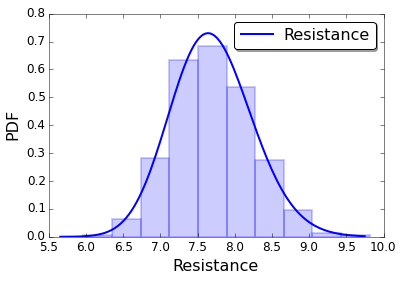

In [3]:
variable = input_distribution.getMarginal(0)
sample = variable.getSample(1000)

fig, ax = pl.subplots()

View(ot.VisualTest.DrawHistogram(sample, 10), axes=[ax],
                            bar_kwargs={'color':'b', 'alpha':0.2,
                                        'edgecolor':'b',
                                        'linewidth':2.,
                                        'label':''}) 

View(variable.drawPDF(), axes=[ax], plot_kwargs={'color':'b', 'lw':2.,
                                                 'label':variable.getDescription()[0]})
ax.grid()

## Définition de la fonction d'état-limite

En fiabilité, la fonction d'état-limite permet de caractériser la défaillance. Dans **OpenTURNS**, on la définit comme une fonction mathématique (`NumericalMathFunction`). Cette fonction mathématique peut-être:

- *explicite (analytique)* et implémentée au moyen d'une simple formule (une chaîne de caractères interprétée par MuParser);
- *implicite (numérique)* et implementée au choix:
    - sous la forme d'une fonction Python (`PythonFunction`);
    - sous la forme d'une librairie externe compilée (formalisme du wrapper **OpenTURNS**).

NB: Par convention, de nombreux auteurs en fiabilité des structures définissent leur fonction d'état-limite de façon à ce que la défaillance soit caractérisée par des valeurs négatives de la fonction d'état-limite. **OpenTURNS** permet de se faire sa propre convention en renseignant explicitement la valeur seuil et l'opérateur de comparaison au moment de la définition de l'évènement redouté.

In [4]:
# A partir d'une formule analytique simple (une ligne)...
g = ot.NumericalMathFunction(['r', 's'], ['g'], ['r - s'])
g.enableCache()
print 'Fonction', g
print 'gradient', g.getInitialGradientImplementation()
print 'Hessien', g.getInitialHessianImplementation()

Fonction [r,s]->[r - s]
gradient 
| d(g) / d(r) = 1 
| d(g) / d(s) = -1 

Hessien 
|   d^2(g) / d(r)^2 = 0 
| d^2(g) / d(s)d(r) = 0 
|   d^2(g) / d(s)^2 = 0 



In [5]:
# A partir d'une fonction numérique implémentée en Python
def g_(X):
    """Fonction d'état limite implémentée en Python."""
    X = np.atleast_2d(X)
    return np.atleast_2d(X[:, 0] - X[:, 1]).T
g = ot.PythonFunction(n=2, p=1, func_sample=g_)
g.setDescription(['r', 's', 'g'])
print 'Fonction', g
print 'gradient', g.getGradient()
print 'Hessien', g.getHessian()

Fonction class=PythonNumericalMathEvaluationImplementation name=OpenTURNSPythonFunction
gradient CenteredFiniteDifferenceGradient epsilon : [1e-05,1e-05]
Hessien CenteredFiniteDifferenceHessian epsilon : [0.0001,0.0001]


Le calcul des dérivées partielles de la fonction ainsi déclarée se fait par différence finie dans le cas d'une fonction implicite. Le schéma (et le pas) de différence finie peut être (et **doit être**) personnalisé !

In [6]:
g.setGradient(
    ot.NonCenteredFiniteDifferenceGradient(
        np.array(input_distribution.getStandardDeviation()) * 5e-2,
        g.getEvaluation()))
g.setHessian(
    ot.CenteredFiniteDifferenceHessian(
        np.array(input_distribution.getStandardDeviation()) * 5e-2,
        g.getEvaluation()))
print 'Fonction', g
print 'gradient', g.getGradient()
print 'Hessien', g.getHessian()

Fonction class=PythonNumericalMathEvaluationImplementation name=OpenTURNSPythonFunction
gradient NonCenteredFiniteDifferenceGradient epsilon : [0.0275,0.0275]
Hessien CenteredFiniteDifferenceHessian epsilon : [0.0275,0.0275]


A l'usage...

In [7]:
print('Valeur de la fonction à la moyenne:')
print(g(input_distribution.getMean()))
print('Valeur du gradient à la moyenne:')
print(g.gradient(input_distribution.getMean()))
print('Valeur du hessien à la moyenne:')
print(g.hessian(input_distribution.getMean()))

Valeur de la fonction à la moyenne:
[6.6]
Valeur du gradient à la moyenne:
[[  1 ]
 [ -1 ]]
Valeur du hessien à la moyenne:
sheet #0
[[ 5.87225e-13 0           ]
 [ 0           2.93613e-13 ]]


## Définition de la marge

On appelle *marge*, la variable décrivant la marge de sûreté d'une réalisation. C'est donc le résultat de l'évaluation de la fonction d'état-limite. Dans le contexte d'une analyse de fiabilité, les variables d'entrée de la fonction d'état-limite étant aléatoires, la *marge* est elle aussi une variable aléatoire.

Dans **OpenTURNS**, on l'implémente comme un *vecteur aléatoire* (`RandomVector`) définit par propagation. Contrairement à la distribution des paramètres d'entrée, on ne connait pas la distribution de ce *vecteur aléatoire*, donc on ne connait pas ses fonctions de densité, de répartition, ses moments, etc. ... On peut néanmoins en générer des réalisations (par propagation).

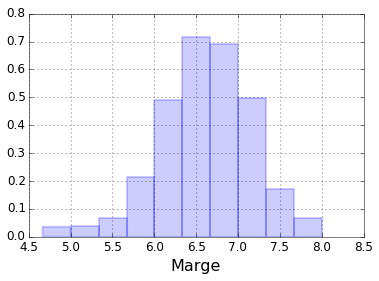

In [8]:
G = ot.RandomVector(g, ot.RandomVector(input_distribution))
G.setDescription(['Marge'])
sample = G.getSample(1000)
pl.hist(np.ravel(sample), normed=True, alpha=.2, color='b', edgecolor='b', linewidth=2.)
pl.xlabel(G.getDescription()[0])
pl.grid()

## Définition de l'évènement redouté

Enfin, pour compléter la définition d'un problème de fiabilité, on définit l'évènement redouté comme un `Event` **OpenTURNS** qui va synthétiser toute la modélisation. C'est donc ce seul objet qui sera transmis à l'ensemble des algorithmes de fiabilité utilisables dans **OpenTURNS** et **PhimecaSoft**.

In [9]:
failure = ot.Event(G, ot.LessOrEqual(), 0.)
failure.setDescription(["La contrainte dépasse la résistance"])

# Autres exemples

## Der Kiureghian & Dakessian (1998)

Un exemple à deux "points de défaillance les plus probables" pour montrer les limites des approches basées sur l'hypothèse d'unicité d'un tel point (FORM, SORM, et MPFP-IS)

Dans cet exemple, la fonction d'état-limite est définie comme suit:

$g(x_1, x_2) = b - x_2 - \kappa\,(x_1 - e) ^ 2$,

et $\mathbf{X} \sim \mathcal{N}_2(\mathbf{0}, \mathbf{1})$.

Le paramètre d'excentricité $e > 0$ permet de favoriser l'influence un point de défaillance plutôt qu'un autre dans la probabilité, le coefficient $\kappa > 0$ contrôle la courbure de l'état-limite.

## Du disque au rectangle (perte de gradient)

Un état-limite de type "circulaire" que l'on peut faire tendre vers un "rectangle" en manipulant l'exposant $k$.

Dans cet exemple, la fonction d'état-limite est définie comme suit:

$g(x_1, x_2) = s\,\left[\left((x_1 - c_1)^{2\,k} + (x_2 - c_2)^{2\,k}\right) - r^{2\,k}\right]$,

et $\mathbf{X} \sim \mathcal{N}_2(\mathbf{0}, \mathbf{1})$.

Le coefficient $s \in \{-1; 1\}$ contrôle le sens dans lequel on définit la défaillance: l'intérieur ($s = 1$) ou l'extérieur ($s = -1$) du cercle de centre de coordonnées $\mathbf{c} = (c_1,\,c_2)^{\mathrm T}$.

En augmentant l'exposant $k$, la fonction d'état-limite s'applatit au voisinage du centre  rendant ainsi la plupart des méthodes fiabilistes impuissantes, car la plupart s'appuie sur l'existence d'un gradient non-nul pour guider progressivement les simulations vers la défaillance.

# Transformation isoprobabiliste et représentations 2D du problème

La *transformation isoprobabiliste* programmée dans **OpenTURNS** permet systématiquement de se ramener d'un vecteur aléatoire quelconque à un vecteur aléatoire gaussien de moyenne nulle et de covariance unitaire.

Cette *standardisation* du problème permet:

- de construire de bonnes approximations de la probabilité de l'évènement redouté (voir les méthodes FORM/SORM) ;
- de régler les autres algorithmes de manière robuste (*i.e.* indépendamment de l'ordre de grandeur des variables du problème).

Examinons ses effets par des représentations 2D.

In [10]:
def plot_in_standard_space(lim=6, res=50, ax=None, g0=0.):
    if ax is None:
        ax = pl.figure(figsize=(8, 8)).add_subplot(111)
    u1_plot, u2_plot = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
    uu_plot = np.vstack([u1_plot.ravel(), u2_plot.ravel()]).T
    Tinv = input_distribution.getInverseIsoProbabilisticTransformation()
    gu_plot = np.reshape(g(Tinv(uu_plot)), (res, res))
    fu_plot = np.reshape(ot.Normal(2).computePDF(uu_plot), (res, res))
    im = ax.imshow(np.flipud(fu_plot), cmap=light_gray, extent=(-lim, lim, -lim, lim))
    cb = pl.colorbar(im)
    cb.set_label('$\\varphi(\mathbf{u})$')
    ax.contourf(u1_plot, u2_plot, gu_plot, [-np.inf, g0], colors='r', alpha=.2)
    c = ax.contour(u1_plot, u2_plot, gu_plot, [g0], colors='r', linestyles='solid', lw=2.)
    pl.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{u}) = %.2f$' % g0))
    ax.set_title('Standard space')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect(1.)
    ax.set_xlabel('$u_1$')
    ax.set_ylabel('$u_2$')
    origin = np.zeros(2)
    ax.plot(origin[0], origin[1], 'k.', markersize=15)
    pl.text(origin[0], origin[1], '$\mathbf{O}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    pl.axvline(origin[0], color='k', linestyle='dashdot', linewidth=1.)
    pl.axhline(origin[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

In [11]:
def plot_in_physical_space(lim=6, res=50, ax=None, g0=0.):
    if ax is None:
        ax = pl.figure(figsize=(8, 8)).add_subplot(111)
    x1_lim = (input_distribution.getMarginal(0).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(0).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x2_lim = (input_distribution.getMarginal(1).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(1).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x1_plot, x2_plot = np.meshgrid(np.linspace(x1_lim[0], x1_lim[1], res),
                                   np.linspace(x2_lim[0], x2_lim[1], res))
    xx_plot = np.vstack([x1_plot.ravel(), x2_plot.ravel()]).T
    gx_plot = np.reshape(g(xx_plot), (res, res))
    fx_plot = np.reshape(input_distribution.computePDF(xx_plot), (res, res))
    im = ax.imshow(np.flipud(fx_plot), cmap=light_gray, extent=(x1_lim[0], x1_lim[1], x2_lim[0], x2_lim[1]))
    cb = pl.colorbar(im)
    cb.set_label('$f_{\mathbf{X}}(\mathbf{x})$')
    ax.contourf(x1_plot, x2_plot, gx_plot, [-np.inf, g0], colors='r', alpha=.2)
    c = ax.contour(x1_plot, x2_plot, gx_plot, [g0], colors='r', linestyles='solid', lw=2.)
    pl.clabel(c, fmt=FormatFaker('$g(\mathbf{x}) = %.2f$' % g0))
    ax.set_title('Physical space')
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
    #ax.set_aspect(np.diff(x1_lim) / np.diff(x2_lim))
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    median = input_distribution.computeQuantile(.5)
    ax.plot(median[0], median[1], 'k.', markersize=15)
    pl.text(median[0], median[1], '$\mathbf{X}_{50\%}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    pl.axvline(median[0], color='k', linestyle='dashdot', linewidth=1.)
    pl.axhline(median[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

/home/dumas/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/dumas/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


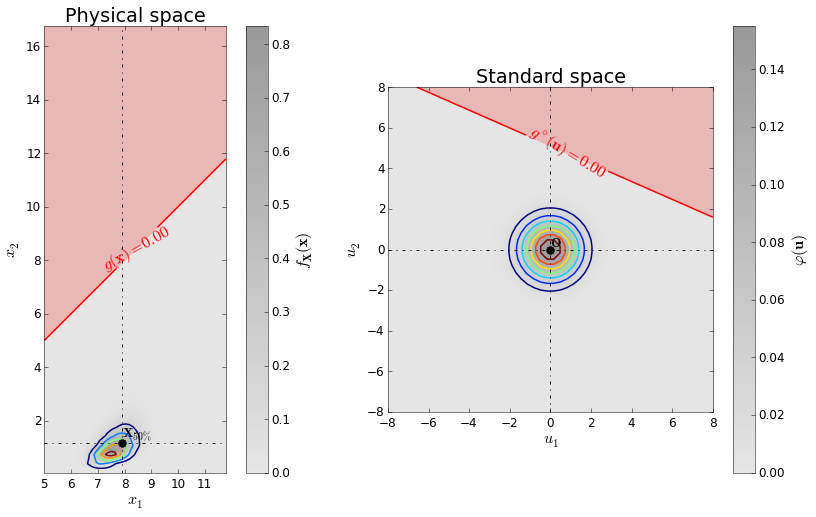

In [12]:
fig = pl.figure(figsize=(16, 8))
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
_ = ax.contour(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['fx_plot'], cmap=pl.matplotlib.cm.jet)
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122), lim=8.)
_ = ax.contour(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['fu_plot'], cmap=pl.matplotlib.cm.jet)

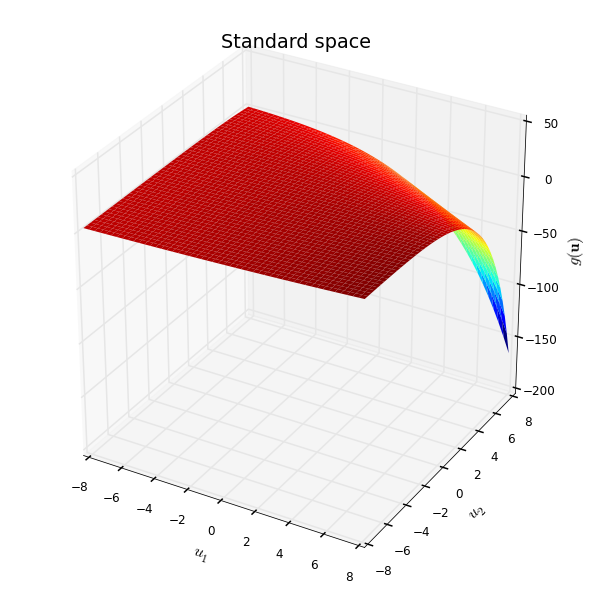

In [13]:
fig = pl.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                cmap=pl.matplotlib.cm.jet, rstride=1, cstride=1, lw=0.)
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.set_zlabel('$g(\mathbf{u})$')
_ = ax.set_title('Standard space')

La transformation isoprobabiliste *conserve les probabilités*, donc *la probabilité de défaillance calculée dans l'espace physique est **la même** que celle calculée dans l'espace standar*d. Néanmoins, *ses approximations peuvent être **différentes*** d'un espace à l'autre car la géométrie n'est pas la même.

# Estimation par simple simulation de Monte Carlo

La simulation de Monte Carlo est la méthode d'estimation de référence. Néanmoins, son coût de calcul est inversement proportionnel à la probabilité à estimer, ce qui la rend tout simplement innaplicable dès lors que la probabilité est faible et le modèle coûteux à évaluer.

In [14]:
g.enableHistory()
g.clearHistory()

In [16]:
MCS_algorithm = ot.MonteCarlo(failure)
MCS_algorithm.setMaximumCoefficientOfVariation(.3)
MCS_algorithm.setMaximumOuterSampling(int(1e1))
MCS_algorithm.setBlockSize(int(1e5))
MCS_algorithm.run()
MCS_results = MCS_algorithm.getResult()
MCS_evaluation_number = g.getHistoryInput().getSample().getSize()

In [17]:
print('Probability estimate: %.3e' % MCS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % MCS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % MCS_evaluation_number)

Probability estimate: 1.000e-06
Coefficient of variation: 1.00
Number of evaluations: 2000000


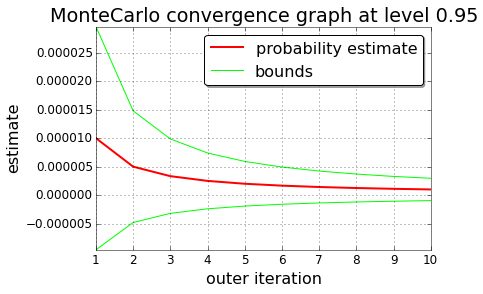

In [23]:
View(MCS_algorithm.drawProbabilityConvergence()).show()

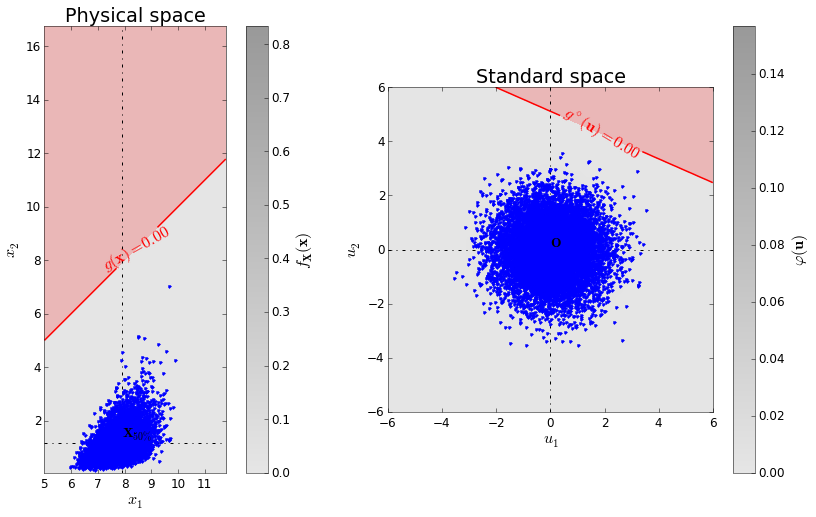

In [19]:
fig = pl.figure(figsize=(16, 8))
input_sample = np.array(g.getHistoryInput().getSample())[:int(1e4)]
output_sample = np.ravel(g.getHistoryOutput().getSample())[:int(1e4)]
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
_ = ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

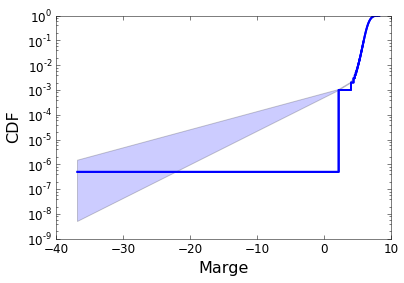

In [21]:
fig = pl.figure()
sample_G = g.getHistoryOutput().getSample()
g_plot = np.sort(np.ravel(sample_G))[::sample_G.getSize() / int(1e3)]
p_plot = np.ravel([sample_G.computeEmpiricalCDF([g_value]) for g_value in g_plot])
cov_plot = np.sqrt((1. - p_plot) / float(sample_G.getSize()) / p_plot)
p_plot_plus = p_plot * (1. + 1.96 * cov_plot)
p_plot_plus[p_plot_plus > 1.] = np.nan
p_plot_minus = p_plot * (1. - 1.96 * cov_plot)
p_plot_minus[p_plot_minus < p_plot.min() * 1e-2] = p_plot.min() * 1e-2
pl.plot(g_plot, p_plot, 'b-', drawstyle='steps-post', lw=2.)
pl.plot(g_plot, p_plot, 'b-', drawstyle='steps-post', lw=2.)
pl.fill_between(g_plot, p_plot_minus, p_plot_plus, facecolor='b', alpha=.2)
pl.yscale('log')
pl.xlabel(G.getDescription()[0])
pl.ylabel('CDF')
_ = pl.ylim(pl.ylim()[0], 1.)

# Approches basées sur le point de défaillance le plus probable

## Recherche du point de défaillance le plus probable (MPFP)

In [347]:
g.enableHistory()
g.clearHistory()

In [348]:
design_point_algorithm = ot.AbdoRackwitz()
Tinv = input_distribution.getInverseIsoProbabilisticTransformation()
design_point_algorithm.setLevelFunction(ot.NumericalMathFunction(g, Tinv))
design_point_algorithm.setStartingPoint([0., 0.])
design_point_algorithm.run()
search_results = design_point_algorithm.getResult()
design_point_in_standard_space = search_results.getMinimizer()
design_point_in_physical_space = Tinv(design_point_in_standard_space)

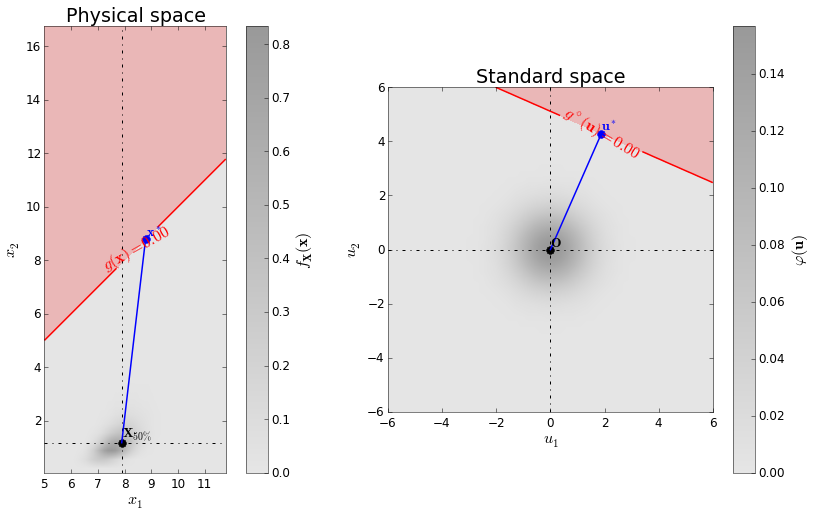

In [349]:
fig = pl.figure(figsize=(16, 8))
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot([input_distribution.computeQuantile(.5)[0], design_point_in_physical_space[0]],
        [input_distribution.computeQuantile(.5)[1], design_point_in_physical_space[1]], 'b-')
ax.plot(design_point_in_physical_space[0], design_point_in_physical_space[1],
        'b.', markersize=15)
pl.text(design_point_in_physical_space[0], design_point_in_physical_space[1],
        '$\mathbf{x}^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
ax.plot([0., design_point_in_standard_space[0]],
        [0., design_point_in_standard_space[1]], 'b-')
ax.plot(design_point_in_standard_space[0], design_point_in_standard_space[1],
        'b.', markersize=15)
pl.text(design_point_in_standard_space[0], design_point_in_standard_space[1],
        '$\mathbf{u}^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})

## First order reliability method (FORM)

In [350]:
g.enableHistory()
g.enableCache()
g.clearHistory()

In [351]:
FORM_algorithm = ot.FORM(design_point_algorithm, failure, input_distribution.computeQuantile(.5))
FORM_algorithm.run()
FORM_results = FORM_algorithm.getResult()
FORM_evaluation_number = g.getInputHistory().getSample().getSize()

In [352]:
print('Hasofer-Lind reliability index: %.2f' % FORM_results.getHasoferReliabilityIndex())
print('First-order approximation of the probability: %.3e' % FORM_results.getEventProbability())
print('Number of evaluations: %d' % FORM_evaluation_number)

Hasofer-Lind reliability index: 4.68
First-order approximation of the probability: 1.439e-06
Number of evaluations: 35


In [228]:
FORM_results.getImportanceFactors()

class=NumericalPointWithDescription name=Importance Factors dimension=2 description=[Resistance,Contrainte] values=[0.141628,0.858372]

In [229]:
xstar = FORM_results.getPhysicalSpaceDesignPoint()
normalDistri = ot.Normal()
Y = np.zeros(2)
for i in xrange(2):
    Y[i] = normalDistri.computeQuantile(input_distribution.getMarginal(i).computeCDF(xstar[i]))[0]

In [230]:
np.array(Y) ** 2 / np.sum(np.array(Y) **2)

array([ 0.14162791,  0.85837209])

In [231]:
g.clearHistory()
g.clearCache()

In [232]:
ustar = FORM_results.getStandardSpaceDesignPoint()
FORM_results.getIsStandardPointOriginInFailureSpace()

False

In [590]:
print FORM_results.getHasoferReliabilityIndexSensitivity()
print FORM_results.getHasoferReliabilityIndex()

[[muLog_marginal_0 : 2.27714, sigmaLog_marginal_0 : 4.28665, gamma_marginal_0 : 0.259229],[muLog_marginal_1 : -2.27714, sigmaLog_marginal_1 : -10.5533, gamma_marginal_1 : -0.259229],[R_2_1_copula : 0]]
4.67939545352


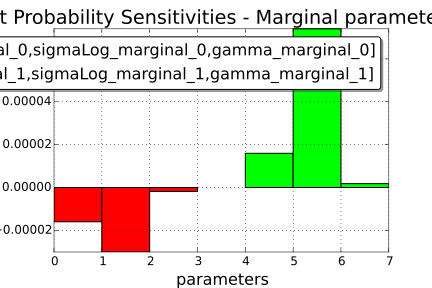

In [593]:
FORM_results.drawEventProbabilitySensitivity()[0]

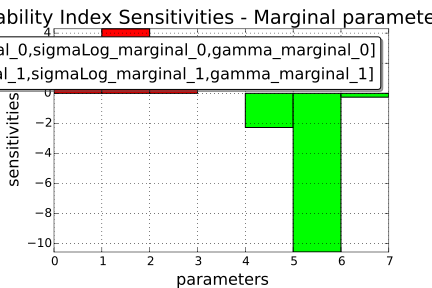

In [592]:
FORM_results.drawHasoferReliabilityIndexSensitivity()[0]

In [553]:
resFORM = ot.FORMResult(ustar, failure, False)

In [579]:
resFORM.getImportanceFactors()

class=NumericalPointWithDescription name=Importance Factors dimension=2 description=[Resistance,Contrainte] values=[0.141628,0.858372]

In [555]:
sens = resFORM.getEventProbabilitySensitivity()
print sens

[[muLog_marginal_0 : -1.59766e-05, sigmaLog_marginal_0 : -3.00759e-05, gamma_marginal_0 : -1.81876e-06],[muLog_marginal_1 : 1.59766e-05, sigmaLog_marginal_1 : 7.40427e-05, gamma_marginal_1 : 1.81876e-06],[R_2_1_copula : -0]]


In [576]:
graph = resFORM.drawImportanceFactors()
graph.setTitle('Importance Factors from design point')

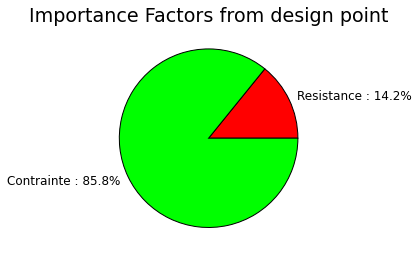

In [577]:
View(graph)

In [547]:
dim = input_distribution.getDimension()
sensitivities = resFORM.getEventProbabilitySensitivity()
elasticities = []
for imarg in xrange(dim):
    
    marg = input_distribution.getMarginal(imarg)
    param = marg.getParametersCollection()[0]
    tmp = [sensitivities[imarg][i] / resFORM.getEventProbability() \
            * np.abs(input_distribution.getParametersCollection()[imarg][i]) for i in xrange(param.getSize())]
    tmp = ot.NumericalPointWithDescription(ot.NumericalPoint(tmp))
    tmp.setName(marg.getDescription()[0])
    tmp.setDescription(param.getDescription())
    elasticities.append(tmp)
    
print elasticities

[class=NumericalPointWithDescription name=Resistance dimension=3 description=[muLog,sigmaLog,gamma] values=[-22.6406,-1.4914,-0], class=NumericalPointWithDescription name=Contrainte dimension=3 description=[muLog,sigmaLog,gamma] values=[0.180594,24.3126,0]]


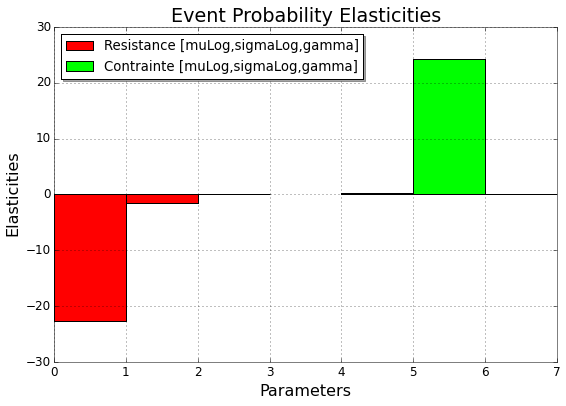

In [545]:
fig = pl.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
countOrigin = 0
dim = len(elasticities)
color = ot.BarPlot.BuildDefaultPalette(dim)

for i, elasticity in enumerate(elasticities):
    data = ot.NumericalSample(elasticity.getSize(), 2)
    data[:, 0] = np.vstack(np.ones(elasticity.getSize()))
    data[:, 1] = np.vstack(elasticity)
    
    label = elasticity.getName() + ' ' + str(elasticity.getDescription())
    
    graph = ot.BarPlot(data, countOrigin)
    countOrigin += elasticity.getSize() + 1

    View(graph, bar_kwargs={'color':color[i], 'label':label}, axes=[ax])

ax.grid()
ax.set_ylabel('Elasticities')
ax.set_xlabel('Parameters')
ax.set_title('Event Probability Elasticities')
ax.legend(loc='upper left', fontsize='small')

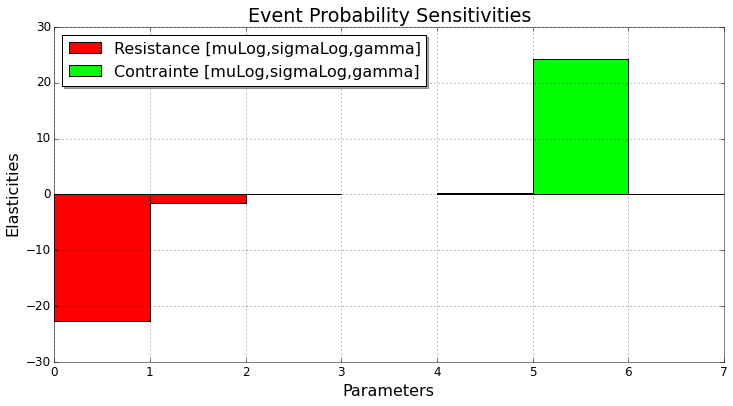

In [483]:
fig = pl.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
countOrigin = 0
dim = input_distribution.getDimension()
color = ot.BarPlot.BuildDefaultPalette(dim)

for iParamCol in xrange(dim):
    param = input_distribution.getMarginal(iParamCol).getParametersCollection()[0]
    param.getSize()
    data = ot.NumericalSample(param.getSize(), 2)
    data[:, 0] = np.vstack(np.ones(3))
    
    elasticity = [resFORM.getEventProbabilitySensitivity()[iParamCol][i] / resFORM.getEventProbability() \
            * np.abs(input_distribution.getParametersCollection()[iParamCol][i]) for i in xrange(param.getSize())]
    
    data[:, 1] = np.vstack(elasticity)
    
    label = input_distribution.getMarginal(iParamCol).getDescription()[0] + ' ' +\
                str(param.getDescription())
    
    graph = ot.BarPlot(data, countOrigin)
    countOrigin += param.getSize() + 1

    View(graph, bar_kwargs={'color':color[iParamCol], 'label':label}, axes=[ax])

ax.grid()
ax.set_ylabel('Elasticities')
ax.set_xlabel('Parameters')
ax.set_title('Event Probability Sensitivities')
ax.legend(loc='upper left')

In [301]:
print [resFORM.getEventProbabilitySensitivity()[1][i] / resFORM.getEventProbability() \
            * np.abs(input_distribution.getParametersCollection()[1][i]) for i in xrange(3)]

[1.2390669373583689, 24.312634503561188, 0.0]


In [297]:
print [resFORM.getEventProbabilitySensitivity()[2][i] / resFORM.getEventProbability() \
            * input_distribution.getParametersCollection()[2][i] for i in xrange(1)]

[-0.0]


In [300]:
input_distribution.getParametersCollection()

[class=NumericalPointWithDescription name=Resistance dimension=3 description=[muLog_marginal_0,sigmaLog_marginal_0,gamma_marginal_0] values=[1.94337,0.0713377,0],class=NumericalPointWithDescription name=Contrainte dimension=3 description=[muLog_marginal_1,sigmaLog_marginal_1,gamma_marginal_1] values=[-0.111572,0.472381,0],class=NumericalPointWithDescription name=NormalCopula dimension=1 description=[R_2_1_copula] values=[0.525]]

In [409]:
graph = resFORM.drawHasoferReliabilityIndexSensitivity()[0]
dr = graph.getDrawables()[1]
dr.getData()

class=NumericalSample name=Unnamed description=[,] implementation=class=NumericalSampleImplementation name=Unnamed size=3 dimension=2 data=[class=NumericalPoint name=Unnamed dimension=2 values=[1,-2.27714],class=NumericalPoint name=Unnamed dimension=2 values=[1,-10.5533],class=NumericalPoint name=Unnamed dimension=2 values=[1,-0.285151]]

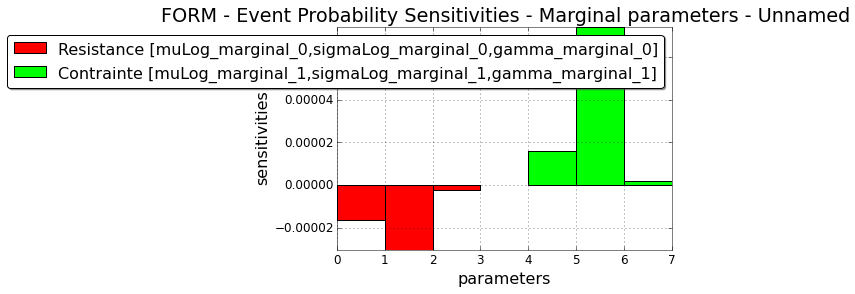

In [267]:
View(resFORM.drawEventProbabilitySensitivity()[0])

## Second-order reliability method (SORM)

In [60]:
g.enableHistory()
g.clearHistory()

In [61]:
SORM_algorithm = ot.SORM(design_point_algorithm, failure, input_distribution.computeQuantile(.5))
SORM_algorithm.run()
SORM_results = SORM_algorithm.getResult()
SORM_evaluation_number = g.getInputHistory().getSample().getSize()

In [62]:
print('Breitung reliability index: %.2f' % SORM_results.getGeneralisedReliabilityIndexBreitung())
print('Breitung second-order approximation of the probability: %.3e' % SORM_results.getEventProbabilityBreitung())

Breitung reliability index: 4.68
Breitung second-order approximation of the probability: 1.439e-06


## Importance factors and reliability sensitivity

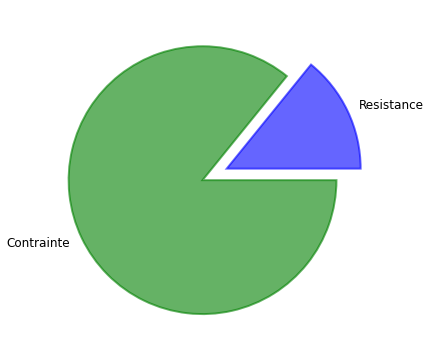

In [63]:
importance_factors = SORM_results.getImportanceFactors()
ax = pl.figure(figsize=(6, 6)).add_subplot(111)
patches = ax.pie(np.array(importance_factors), labels=input_distribution.getDescription(), explode=[.1] * 2)[0]
for patch in patches:
    patch.set_edgecolor(patch.get_facecolor())
    patch.set_linewidth(2.)
    patch.set_alpha(.6)

,elasticities,sensitivities
Resistance (muLog),0.945704,2.277144
Resistance (sigmaLog),0.065352,4.286734
Resistance (gamma),0.000000,0.285151
Contrainte (muLog),-0.054294,-2.277144
Contrainte (sigmaLog),-1.065350,-10.553341
Contrainte (gamma),-0.000000,-0.285151


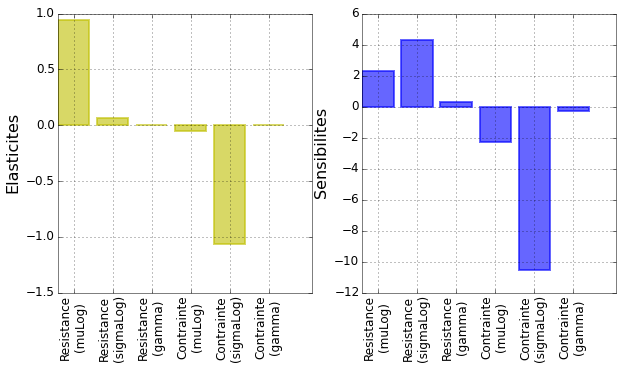

In [64]:
reliability_index_sensitivities = SORM_results.getHasoferReliabilityIndexSensitivity()
reliability_index = SORM_results.getHasoferReliabilityIndex()
sensitivities, elasticities, labels = [], [], []
for i in range(input_distribution.getDimension()):
    marginal = input_distribution.getMarginal(i)
    parameters = marginal.getParametersCollection()[0]
    for j in range(marginal.getParametersNumber()):
        labels.append(marginal.getDescription()[0] + '\n(' + parameters.getDescription()[j] + ')')
        sensitivities.append(reliability_index_sensitivities[i][j])
        elasticities.append(np.abs(parameters[j] / reliability_index) * reliability_index_sensitivities[i][j])

fig = pl.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.bar(np.arange(len(labels)), elasticities, color='y', ec='y', lw=2., alpha=.6)
ax.set_xticks(.4 + np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90., ha='center')
ax.set_xlim(0., len(labels) + .5)
ax.set_ylabel('Elasticites')
ax.grid()
ax = fig.add_subplot(122)
ax.bar(np.arange(len(labels)), sensitivities, color='b', ec='b', lw=2., alpha=.6)
ax.set_xticks(.4 + np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90., ha='center')
ax.set_xlim(0., len(labels) + .5)
ax.set_ylabel('Sensibilites')
ax.grid()

labels = [label.replace('\n', ' ') for label in labels]
pd.DataFrame(dict(sensitivities=sensitivities, elasticities=elasticities),
             index=labels)

## Echantillonnage préférentiel au point de défaillance le plus probable (Tirages d'importance, MPFP-IS)

In [65]:
g.enableHistory()
g.clearHistory()

In [66]:
instrumental_distribution = ot.Normal(design_point_in_standard_space, [1.] * 2, ot.CorrelationMatrix(2))
IS_algorithm = ot.ImportanceSampling(
    ot.StandardEvent(failure),
    instrumental_distribution)
IS_algorithm.setMaximumCoefficientOfVariation(.1)
IS_algorithm.setMaximumOuterSampling(int(1e2))
IS_algorithm.setBlockSize(int(1e1))
IS_algorithm.run()
IS_results = IS_algorithm.getResult()
IS_evaluation_number = g.getInputHistory().getSample().getSize()

In [67]:
print('Probability estimate: %.3e' % IS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % IS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % IS_evaluation_number)

Probability estimate: 1.366e-06
Coefficient of variation: 0.10
Number of evaluations: 610


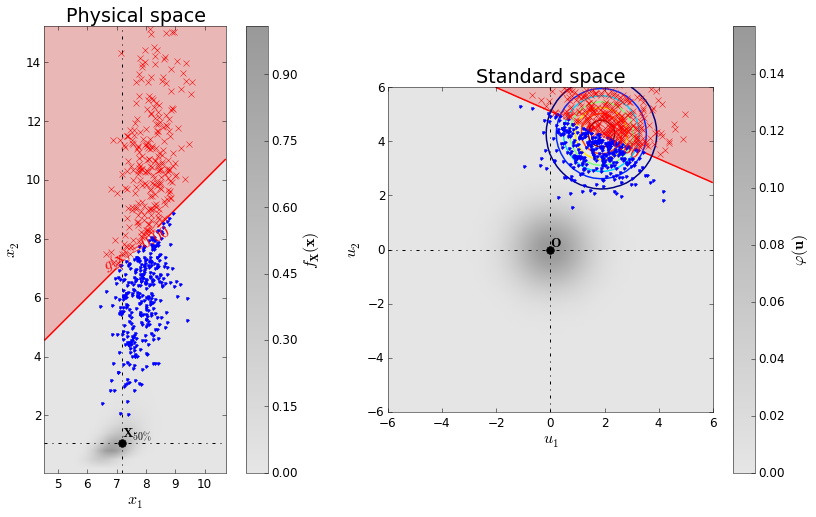

In [68]:
fig = pl.figure(figsize=(16, 8))
input_sample = np.array(g.getInputHistory().getSample())
output_sample = np.ravel(g.getOutputHistory().getSample())
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.contour(data_plot['u1_plot'], data_plot['u2_plot'],
           np.reshape(instrumental_distribution.computePDF(data_plot['uu_plot']),
                      data_plot['u1_plot'].shape),
           cmap=pl.matplotlib.cm.jet)
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
_ = ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

# Estimation par simulations directionnelles

In [69]:
g.enableHistory()
g.clearHistory()

In [70]:
root_strategy = ot.MediumSafe() # Alternatives : ot.SafeAndSlow(), ot.MediumSafe(), ot.RiskyAndFast()
solver = ot.Brent() # Alternatives : ot.Bisection(), ot.Secant(), ot.Brent()
sampling_strategy = ot.OrthogonalDirection() # Alternatives : ot.RandomDirection(), ot.OrthogonalDirection()
sampling_strategy.setDimension(input_distribution.getDimension())
DS_algorithm = ot.DirectionalSampling(failure)
DS_algorithm.setMaximumCoefficientOfVariation(.1)
DS_algorithm.setMaximumOuterSampling(int(1e5))
DS_algorithm.setBlockSize(int(1e0))
DS_algorithm.setRootStrategy(root_strategy)
DS_algorithm.setSamplingStrategy(sampling_strategy)
DS_algorithm.run()
DS_results = DS_algorithm.getResult()
DS_evaluation_number = g.getOutputHistory().getSample().getSize()

In [71]:
print('Probability estimate: %.3e' % DS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % DS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % DS_evaluation_number)

Probability estimate: 1.360e-06
Coefficient of variation: 0.10
Number of evaluations: 4682


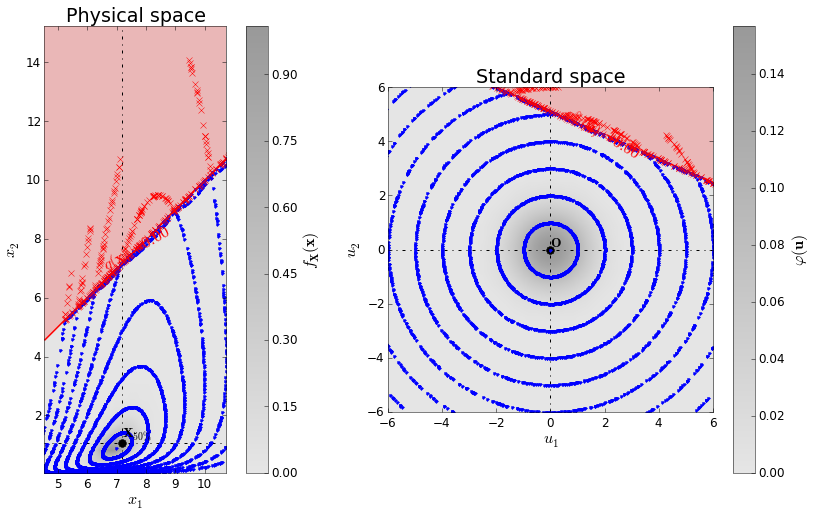

In [72]:
input_sample = np.array(g.getInputHistory().getSample())
output_sample = np.ravel(g.getOutputHistory().getSample())
fig = pl.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax, data_plot = plot_in_physical_space(ax=ax)
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax = fig.add_subplot(122)
ax, data_plot = plot_in_standard_space(ax=ax)
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
_ = ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

# Estimation par subset sampling

In [73]:
g.enableHistory()
g.clearHistory()

In [74]:
SS_algorithm = SubsetSampling(failure)
# Active la simulation conditionnelle à l'étape initiale
#SS_algorithm.setBetaMin(2)
#SS_algorithm.setISubset(1)
# -------------------------------------------------------
SS_algorithm.setMaximumOuterSampling(int(1e2))
SS_algorithm.setBlockSize(int(1e2))
SS_algorithm.run()
SS_results = SS_algorithm.getResult()
SS_evaluation_number = g.getInputHistory().getSample().getSize()

In [75]:
print('Probability estimate: %.3e' % SS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % SS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % SS_evaluation_number)

Probability estimate: 1.520e-06
Coefficient of variation: 0.12
Number of evaluations: 60000


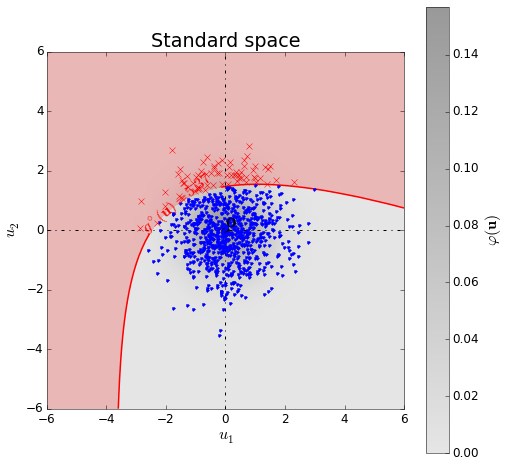

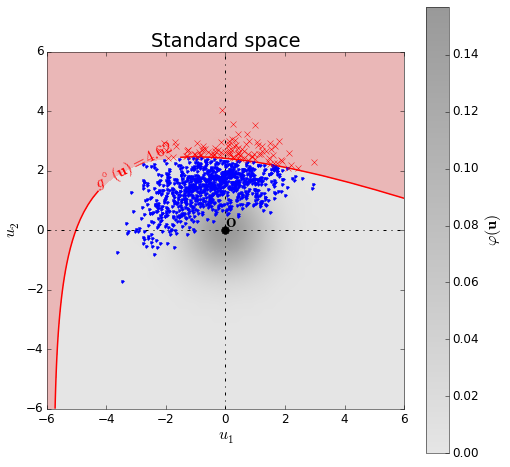

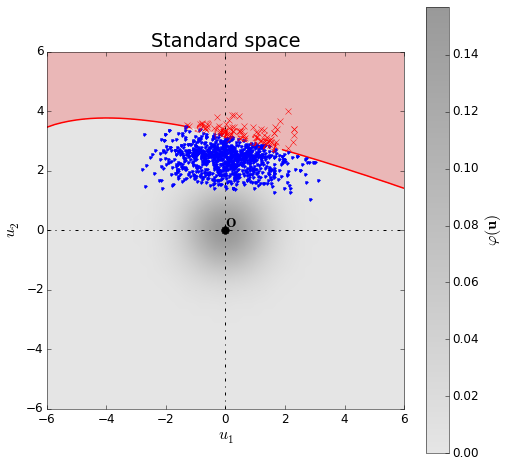

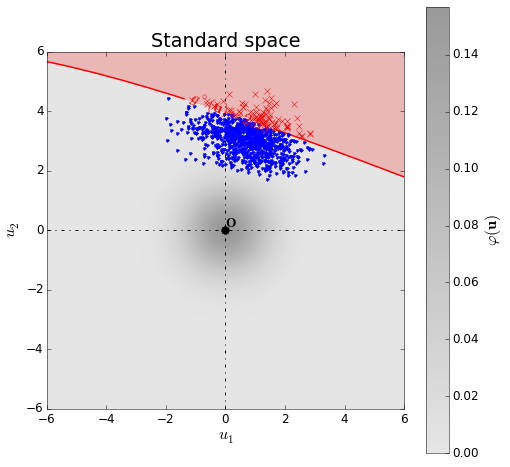

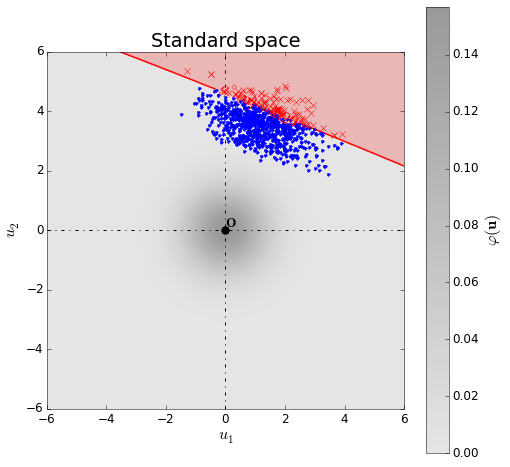

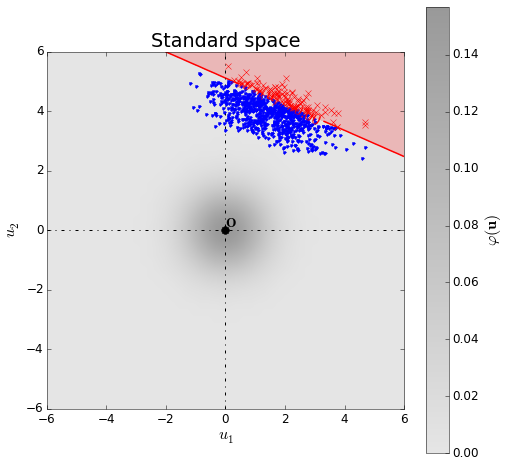

In [79]:
for step in xrange(SS_algorithm.getNumberOfSteps()):
    N = SS_algorithm.getMaximumOuterSampling() * SS_algorithm.getBlockSize()
    thresholds = SS_algorithm.getThresholds()
    input_sample = np.array(g.getInputHistory().getSample())[step * N:(step + 1) * N]
    input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
    output_sample = np.ravel(g.getOutputHistory().getSample())[step * N:(step + 1) * N]
    if step > 0:
        mask = np.ravel(g.getOutputHistory().getSample())[(step - 1) * N:step * N] <= thresholds[step - 1]
    ax, data_plot = plot_in_standard_space(g0=thresholds[step])
    ax.plot(input_sample[mask][output_sample[mask] > thresholds[step], 0],
            input_sample[mask][output_sample[mask] > thresholds[step], 1], 'b.')
    _ = ax.plot(input_sample[mask][output_sample[mask] <= thresholds[step], 0],
                input_sample[mask][output_sample[mask] <= thresholds[step], 1], 'rx')

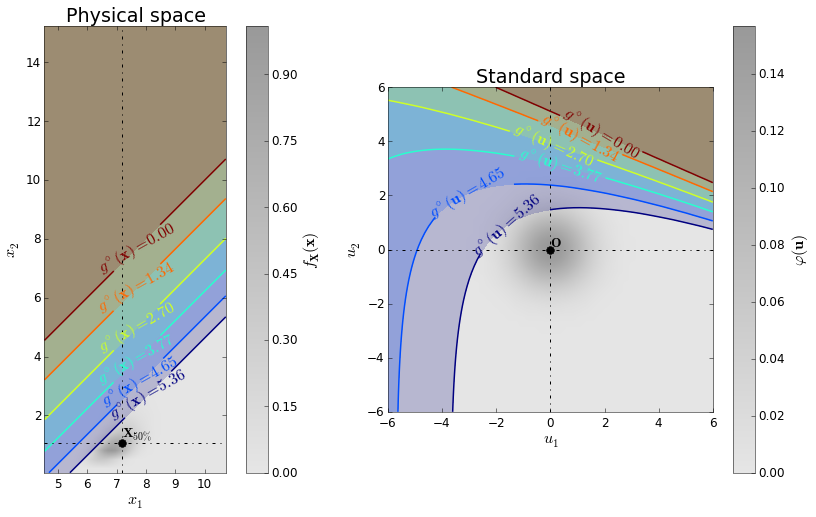

In [43]:
thresholds = np.ravel(SS_algorithm.getThresholds())
fig = pl.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax, data_plot = plot_in_physical_space(g0=-np.inf, ax=ax)
colors = pl.matplotlib.cm.jet(np.linspace(0, 1., thresholds.size))
for threshold, color in zip(thresholds, colors):
    c = ax.contourf(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                    [-np.inf, threshold], colors=[color], alpha=.2)
    c = ax.contour(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                   [threshold], colors=[color], linestyles='solid', lw=2.)
    pl.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{x}) = %.2f$' % threshold))
ax = fig.add_subplot(122)
ax, data_plot = plot_in_standard_space(g0=-np.inf, ax=ax)
colors = pl.matplotlib.cm.jet(np.linspace(0, 1., thresholds.size))
for threshold, color in zip(thresholds, colors):
    c = ax.contourf(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                    [-np.inf, threshold], colors=[color], alpha=.2)
    c = ax.contour(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                   [threshold], colors=[color], linestyles='solid', lw=2.)
    pl.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{u}) = %.2f$' % threshold))